In [78]:
from selenium import webdriver
import time
import re
from tqdm import tqdm
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np

import tushare as ts # 导入tushare包
pro = ts.pro_api('0d40fbdecd4b48b23a711710d05ee3f3f0c0ee04baf377d9580e086f')

In [42]:
#模拟人进入浏览器
stock_code = input('请输入股票代码：')
page_num = input('请输入公告页数：')
driver = webdriver.Chrome(r'D:\code.py\jupyter根目录\爬虫\爬取淘宝网站\chromedriver.exe')
driver.get('http://data.eastmoney.com/notices/stock/{}.html'.format(stock_code))
#driver.find_element_by_xpath('//*[@id="xuanguInput"]').send_keys(kw)
#driver.find_element_by_xpath('/html/body/div[1]/div[1]/div/div[1]/button').click()
# divs = driver.find_element_by_xpath('//a[@class="overflow"]').get_attribute('href')

请输入股票代码： 600519
请输入公告页数： 12


# 获取时间， 标题 ， 文本链接

In [43]:
lj_lists = []
def get_lj():
    divs = driver.find_element_by_xpath('//*[@id="dt_1"]/tbody')
    trs = divs.find_elements_by_tag_name('tr')
    for tr in trs:
        lj = tr.find_element_by_xpath('.//a[@class="overflow"]').get_attribute('href')
        title = tr.find_element_by_xpath('.//a[@class="overflow"]').get_attribute('title')
        date = tr.find_elements_by_tag_name('td')[-1].find_element_by_tag_name('span').text
        lj_lists.append((date,title,lj))

In [44]:
for i in range(int(page_num)):
    print(i,end = ' ')
    if i==0:
        get_lj()
    else:
        driver.find_element_by_css_selector('#PageContgopage').clear()
        driver.find_element_by_css_selector('#PageContgopage').send_keys(i+1)
        driver.find_element_by_css_selector('#PageCont > a.btn_link').click()
        time.sleep(1)
        get_lj()

0 1 2 3 4 5 6 7 8 9 10 11 

# 根据文本链接获取文本

In [45]:
def get_text(lj):
    req = requests.get(lj).text
    bs = BeautifulSoup(req, 'lxml')
    return bs.find_all(attrs={'id': 'notice_content'})[0].get_text().replace('\n','').replace('\r','')

In [46]:
text_dict = {}
i = 0
for i in tqdm(range(len(lj_lists))):
    try:
        lj = lj_lists[i]
        text_dict[i] = (get_text(lj[-1]))
    except:
        time.sleep(1)

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [02:10<00:00,  4.61it/s]


# 整合数据

In [47]:
all_data = []
for i in text_dict.keys():
    all_data.append((lj_lists[i][0],lj_lists[i][1],text_dict[i]))
pdf_all = pd.DataFrame(all_data,columns = ['date','title','text'])
pdf_all['date'] = pd.to_datetime(pdf_all['date'])

In [48]:
# 茅台
dates = [pd.to_datetime(i[0]).date() for i in lj_lists]
df = pro.daily(ts_code='{}.sh'.format(stock_code), start_date=str(min(dates)).replace('-',''), end_date=str(max(dates)).replace('-',''))
df=df.rename(columns={'ts_code':'股票代码','trade_date':'交易日期','open':'开盘价','high':'当日最高价','low':'当日最低价','close':'收盘价','pre_close':'昨收价',
                     'change':'涨跌额','pct_chg':'涨跌幅','vol':'成交量 （手）','amount':'成交额 （千元）'})
df = df[['交易日期','收盘价']]
df['交易日期'] = pd.to_datetime(df['交易日期'])
df.sort_values('交易日期',inplace = True)
df = df.rename(columns = {'交易日期':'date'})
df['date'] = pd.to_datetime(df['date'])
df.set_index('date',inplace = True)
tmp = (df.diff().dropna() > 0).astype(np.int).rename(columns={'收盘价':'flag'})


In [49]:
result = pdf_all.merge(tmp,on = 'date',how = 'inner')

In [51]:
result.to_csv('mt.csv',index = False)

In [52]:
gj = pd.read_csv('gj.csv')
mt = pd.read_csv('mt.csv')
wly = pd.read_csv('wly.csv')
lzlj = pd.read_csv('lzlj.csv')

In [53]:
df_concat = pd.concat([gj,mt,wly,lzlj])
df_concat.to_csv('未处理.csv',index=False)

# 数据处理

In [34]:
gj = pd.read_csv('古井贡酒.csv')
mt = pd.read_csv('茅台公告.csv')
wly = pd.read_csv('五粮液公告.csv')
lzlj = pd.read_csv('泸州老窖.csv')

In [35]:
import re

In [36]:
reg = "[^0-9A-Za-z\u4e00-\u9fa5]"
for i in result.index:
    result.loc[i,'text'] = re.sub(reg,'',result.loc[i,'text'])

In [37]:
result.to_csv('泸州老窖.csv',index=False)

In [38]:
df_concat = pd.concat([gj,mt,wly,lzlj])
df_concat

date                             title  \
0    2020-11-25        古井贡酒:关于召开2020年第一次临时股东大会的通知   
1    2020-11-25  古井贡酒:关于公司非公开发行A股股票事项获国家出资企业批复的公告   
2    2020-11-25              古井贡酒:第九届董事会第五次会议决议公告   
3    2020-11-16                    古井贡酒:重大事项提示性公告   
4    2020-10-29           古井贡B:2020年第三季度报告全文(英文版)   
..          ...                               ...   
867  2000-05-11    泸州老窖股份有限公司董事会关于增加一名第三届董事会董事候选人   
868  2000-04-28  泸州老窖股份有限公司董事会关于增加1999年度股东大会议题的公告   
869  2000-04-11                 泸州老窖股份有限公司董事会决议公告   
870  2000-04-11                 泸州老窖股份有限公司监事会决议公告   
871  2000-04-11             泸州老窖股份有限公司1999年年度报告摘要   

                                                  text  flag  
0    证券代码000596200596证券简称古井贡酒古井贡B公告编号2020037安徽古井贡酒股...     0  
1    证券代码000596200596证券简称古井贡酒古井贡B公告编号2020036安徽古井贡酒股...     0  
2    证券代码000596200596证券简称古井贡酒古井贡B公告编号2020035安徽古井贡酒股...     0  
3    证券代码000596200596证券简称古井贡酒古井贡B公告编号2020034安徽古井贡酒股...     1  
4    ANHUIGUJINGDISTILLERYCOMPANYLIMITEDTHIRDQUARTE...     0  
..                                                 ...   ...  
867                          泸州老窖股份有限公司董事会         ...     0  
868                                 泸州老窖股份有限公司董事会  ...     1  
869                         泸州老窖股份有限公司董事会决议公告　　泸州老窖...     1  
870                        泸州老窖股份有限公司监事会决议公告　　泸州老窖股...     1  
871                       泸州老窖股份有限公司1999年年度报告摘要    ...     1  

[2832 rows x 4 columns]

In [40]:
df_concat.to_csv('data.csv')

### 数据挖掘

In [79]:
import pandas as pd
import re
data = pd.read_csv('茅台公告.csv',encoding = 'utf-8')
from datetime import timedelta
from datetime import datetime

In [80]:
data['date'] = pd.to_datetime(data['date']) +timedelta(days=1)

In [81]:
min_date = data['date'].min()
max_date = data['date'].max()
stock_code = 600519

In [82]:
df = pro.daily(ts_code='{}.sh'.format(stock_code), start_date=str(min_date).replace('-',''), end_date=str(max_date).replace('-',''))
df=df.rename(columns={'ts_code':'股票代码','trade_date':'date','open':'开盘价','high':'当日最高价','low':'当日最低价','close':'收盘价','pre_close':'昨收价',
                     'change':'涨跌额','pct_chg':'涨跌幅','vol':'成交量 （手）','amount':'成交额 （千元）'})
df = df[['date','收盘价']]
df['date'] = pd.to_datetime(df['date'])

In [83]:
df['收盘价'] = df['收盘价'].diff().apply(lambda x : 1 if x<0 else 0)

In [84]:
data = data.merge(df,on='date',how='inner')

In [85]:
data.drop('flag',axis=1,inplace=True)
data.rename(columns={'收盘价':'flag'},inplace=True)

In [ ]:
reg = "[^\u4e00-\u9fa5\;\。\，\！\？]"
for i in data.index:
    data.loc[i,'text'] = re.sub(reg,'',data.loc[i,'text'])
with open('hh.txt','w' , encoding='utf-8') as f:
    pass
with open('hh.txt','a', encoding='utf-8') as f:
    for i in range(len(data)):
        f.write(data.values[i][0] + "\n")

### 情绪分析

In [24]:
print('茅台新闻公告发布后，股价上升的概率为：',1-(len(data)-data['flag'].sum())/len(data))

茅台新闻公告发布后，股价上升的概率为： 0.7490494296577948


In [25]:
data['flag'].sum()

394

In [26]:
len(data)-data['flag'].sum()

132

In [5]:
import pyecharts.options as opts
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_LAB
import matplotlib.pyplot as plt
%matplotlib inline
from pyecharts.charts import Pie

"""
Gallery 使用 pyecharts 1.1.0
参考地址: https://echarts.baidu.com/examples/editor.html?c=pie-nest

目前无法实现的功能:

1、暂无
"""

inner_x_data = ['消极情绪','积极情绪','中立']
inner_y_data = [132,496,5]
inner_data_pair = [list(z) for z in zip(inner_x_data, inner_y_data)]

outer_x_data =['消极情绪','积极情绪','中立']
outer_y_data = [132,496,5]
outer_data_pair = [list(z) for z in zip(outer_x_data, outer_y_data)]

pie = (
    Pie(init_opts=opts.InitOpts(width="1600px", height="800px"))
    .add(
        series_name="访问来源",
        data_pair=inner_data_pair,
        radius=[0, "30%"],
        label_opts=opts.LabelOpts(position="inner"),
    )
    .add(
        series_name="访问来源",
        radius=["40%", "55%"],
        data_pair=outer_data_pair,
        label_opts=opts.LabelOpts(
            position="outside",
            formatter="{a|{a}}{abg|}\n{hr|}\n {b|{b}: }{c}  {per|{d}%}  ",
            background_color="#eee",
            border_color="#aaa",
            border_width=1,
            border_radius=4,
            rich={
                "a": {"color": "#999", "lineHeight": 22, "align": "center"},
                "abg": {
                    "backgroundColor": "#e3e3e3",
                    "width": "100%",
                    "align": "right",
                    "height": 22,
                    "borderRadius": [4, 4, 0, 0],
                },
                "hr": {
                    "borderColor": "#aaa",
                    "width": "100%",
                    "borderWidth": 0.5,
                    "height": 0,
                },
                "b": {"fontSize": 16, "lineHeight": 33},
                "per": {
                    "color": "#eee",
                    "backgroundColor": "#334455",
                    "padding": [2, 4],
                    "borderRadius": 2,
                },
            },
        ),
    )
    .set_global_opts(legend_opts=opts.LegendOpts(pos_left="left", orient="vertical"))
    .set_series_opts(
        tooltip_opts=opts.TooltipOpts(
            trigger="item", formatter="{a} <br/>{b}: {c} ({d}%)"
        )
    )
    
)

In [6]:
pie.load_javascript()

In [7]:
pie.render_notebook()

### 词云

In [ ]:
from os import path
import pandas as pd
from wordcloud import WordCloud
import re
import jieba
import matplotlib.pyplot as plt
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']

In [10]:
data = pd.read_csv('mt.csv')

In [11]:
reg = "[^\u4e00-\u9fa5\;\。\，\！\？]"
for i in data.index:
    data.loc[i,'text'] = re.sub(reg,'',data.loc[i,'text'])

In [12]:
text = data['text']

In [13]:
st=''
for i in text.index:
    st+=text[i]

In [15]:
wordlist = jieba.cut(st, cut_all=True) # 结巴分词
wl = " ".join(wordlist)

In [16]:
wordcloud = WordCloud(collocations=False,font_path='msyh.ttc',background_color="white", max_font_size=40).generate(wl)

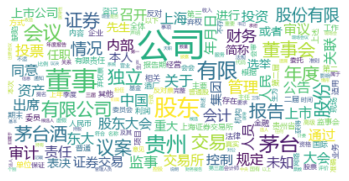

In [17]:
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")#取消图表x、y轴
plt.show()

In [18]:
wordcloud.to_file('茅台词云.jpg')